In [ ]:
%reload_ext autoreload
%autoreload 2

In [1]:
import os
import json
import pandas as pd
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split

from k12libs.utils.nb_easy import K12AI_DATASETS_ROOT
from k12libs.utils.nb_dataset import k12ai_compute_mean_std

# <div align="center"> Compute Mean and Std </div>

## 全量

In [ ]:
# datadir = os.path.join(K12AI_DATASETS_ROOT, 'cv', 'dogsVsCats')
# jfiles = ['train.json', 'val.json', 'test.json']
# mean, std = k12ai_compute_mean_std(datadir=datadir, jfiles=jfiles)

In [ ]:
# mean, std
# [0.1349, 0.1349, 0.1349], 0.1349, 0.1349, 0.1349]

| mean | std |
| :---: | :---: |
|<img width=200/> | <img width=200/>
|[0.1349, 0.1349, 0.1349] | [0.2976, 0.2976, 0.2976] |

## 精简

In [2]:
train_val_json = os.path.join(K12AI_DATASETS_ROOT, 'cv', 'dogsVsCats', 'train_val.json')
items = []
with open(train_val_json, 'r') as f:
    items = json.load(f)
len(items)

18000

### 读取

In [3]:
train_val_df = pd.read_json(train_val_json, encoding="utf-8", orient='records')
train_val_df[:5]

,image_path,label
0,imgs/train/dog.2983.jpg,0
1,imgs/train/dog.10127.jpg,0
2,imgs/train/cat.7282.jpg,1
3,imgs/train/cat.10214.jpg,1
4,imgs/train/dog.9504.jpg,0


### 查看是否均匀分布

In [4]:
grouped_by_label = train_val_df.groupby('label')
grouped_by_label.count()

,image_path
label,
0,9058
1,8942


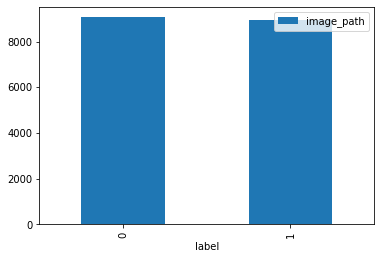

In [5]:
grouped_by_label.count().plot(kind='bar');

### 随机精简

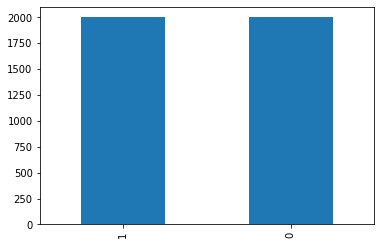

In [6]:
# 合理: 先分组, 然后组中随机样本
reduced_df = train_val_df.groupby('label').apply(pd.DataFrame.sample, n=2000, random_state=20, replace=False)
reduced_df['label'].value_counts().plot(kind='bar');

### 对样本随机打散

In [7]:
reduced_shuffle_df = reduced_df.sample(frac=1)
reduced_shuffle_df[15:25]

image_path  label
label                                       
1     12194  imgs/train/cat.11052.jpg      1
0     15435  imgs/train/dog.12428.jpg      0
      7933   imgs/train/dog.10065.jpg      0
      6773    imgs/train/dog.4577.jpg      0
1     6960    imgs/train/cat.6188.jpg      1
      10747   imgs/train/cat.6545.jpg      1
      17689   imgs/train/cat.2515.jpg      1
0     3451    imgs/train/dog.9908.jpg      0
      14891   imgs/train/dog.1369.jpg      0
1     6159    imgs/train/cat.4150.jpg      1

### 分割数据集6:2:2

In [8]:
train_valid_df, test_df = train_test_split(reduced_shuffle_df, test_size=0.2)
train_df, valid_df = train_test_split(train_valid_df, test_size=0.2)
len(train_df), len(valid_df), len(test_df), len(reduced_shuffle_df)

(2560, 640, 800, 4000)

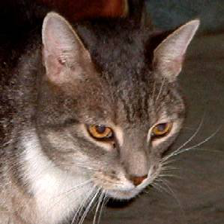

In [10]:
image_path = test_df[0:10]['image_path'].tolist()[0]
image_path = os.path.join(K12AI_DATASETS_ROOT, 'cv', 'dogsVsCats', image_path)
Image.open(image_path).resize((224, 224))

## 保存精简数据集rmnist

In [11]:
def generate_rdogsvscats(df, phase):
    src_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', 'dogsVsCats')
    dst_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', 'rDogsVsCats')
    
    img_path = os.path.join(dst_root, 'imgs', phase)
    shutil.rmtree(img_path, ignore_errors=True)
    os.makedirs(img_path)
    
    results = []
    items = df.to_dict(orient='records')
    print(f'{phase} count: {len(items)}')
    for item in items:
        filename = os.path.basename(item['image_path'])
        src_path = os.path.join(src_root, item['image_path'])
        dst_path = os.path.join(img_path, filename)
        if not os.path.exists(src_path):
            print('not found:', src_path)
        if os.path.exists(dst_path):
            print('replce found:', dst_path)
        results.append({
            'image_path': f'imgs/{phase}/{filename}',
            'label': item['label']
        })
        Image.open(src_path).resize((256, 256)).crop((16, 16, 240, 240)).save(dst_path)
        # shutil.copy2(src_path, dst_path)
        
    with open(os.path.join(dst_root, f'{phase}.json'), 'w') as f:
        json.dump(results, f)
        
generate_rdogsvscats(test_df, 'test')
generate_rdogsvscats(train_df, 'train')
generate_rdogsvscats(valid_df, 'val')

test count: 800
train count: 2560
val count: 640
